# Detailed Balance Efficiency Limit
import necessary packagaes

In [1]:
%config InlineBackend.figure_format = 'retina' #to make inline images higher res

from math import pi
from scipy.integrate import trapz
from scipy.interpolate import interp1d

import numpy as np
import matplotlib.pyplot as plt

define plot style

In [2]:
plt.style.use(['presplot'])

initialize constants, load data

In [3]:
#constants
c=2.998e8 #m/s
h=4.136e-15 #eV s
k=8.617e-5 #eV/K
q=1.602e-19 #C
t_c=300
t_s=5800
omega_s=6.8e-5
omega_c=pi

#bandgaps
e_step=0.001 #step size for bandgaps 
egs=np.arange(e_step,3,e_step) #bandgaps in eV

#am1.5 data
am1p5_raw=np.loadtxt("am1p5_raw.txt")

### SQ limit, AM0

calculate incident power and initialize efficiency array

In [4]:
#incident power
e_tot=np.arange(e_step,8,e_step)
bbe_s=2*omega_s/(h**3*c**2)*e_tot**3/(np.exp(e_tot/(k*t_s))-1)
pinc_am0=q*trapz(bbe_s,e_tot) #W/(m^2) - multiply by q for eV to J

#initialize efficiency
eff_am0=np.zeros(len(egs))

run over bandgaps, find max efficiency

In [5]:
i=0 #initialize index

for eg in egs:
    
    e=np.arange(eg,8,e_step) #integration bounds are e_g to infinity (8 ev here)
    v=np.arange(0,eg,e_step) #voltages from from 0 to bandgap
    
    bb_c=2*omega_c/(h**3*c**2)*e**2/(np.exp(e/(k*t_c))-1) #bb radiation from cell, photons/(m^2*s)
    j0=q*trapz(bb_c,e) #C/(m^2*s) = A/m^2
    
    bb_s=2*omega_s/(h**3*c**2)*e**2/(np.exp(e/(k*t_s))-1) #bb radiation from sun, photons/(m^2*s)
    jsc=q*trapz(bb_s,e) #C/(m^2*s) = A/m^2
    
    j=-(j0*(np.exp(v/(k*t_c))-1)-jsc) #just need v b/c k is in eV/K
    #j=-(j0*(np.exp(v/(k*T_c)))-jsc) #no real difference
    
    pmax=np.max(j*v)
    eff_am0[i]=pmax/pinc_am0
    
    i+=1 #index
    

### SQ limit, AM1.5
calculate incident power and initialize efficiency array

In [6]:
#incident power
ev=1240/am1p5_raw[::-1,0]
am1p5=1/ev**2*1240*am1p5_raw[::-1,1] #W/(m^2 eV)
pinc_am1p5=trapz(am1p5,ev)

#create interpolant
g=interp1d(ev,am1p5,fill_value="extrapolate")

#initialize efficiency
eff_am1p5=np.zeros(len(egs))

run over bandgaps, find max efficiency

In [7]:
i=0 #initialize index

for eg in egs:
    
    e=np.arange(eg,5,e_step) #integration bounds are e_g to infinity (8 ev here)
    v=np.arange(0,eg,e_step) #voltages from from 0 to bandgap
    
    bb_c=2*omega_c/(h**3*c**2)*e**2/(np.exp(e/(k*t_c))-1) #bb radiation from cell, photons/(m^2*s)
    j0=q*trapz(bb_c,e) #C/(m^2*s) = A/m^2
    
    rad_s=g(e)/(q*e) #bb radiation from sun, photons/(m^2*s)
    jsc=q*trapz(rad_s,e) #C/(m^2*s) = A/m^2
    
    j=-(j0*(np.exp(v/(k*t_c))-1)-jsc) #just need v b/c k is in eV/K
    #j=-(j0*(np.exp(v/(k*T_c)))-jsc) #no real difference
    
    pmax=np.max(j*v)
    eff_am1p5[i]=pmax/pinc_am1p5
    
    if eg==1.337: #save I-V data for best device
        jmax=j
        vmax=v
    
    i+=1 #index
    

calculate jsc, voc, ff for best I-V data

### Plots 

plot S-Q efficiency limit

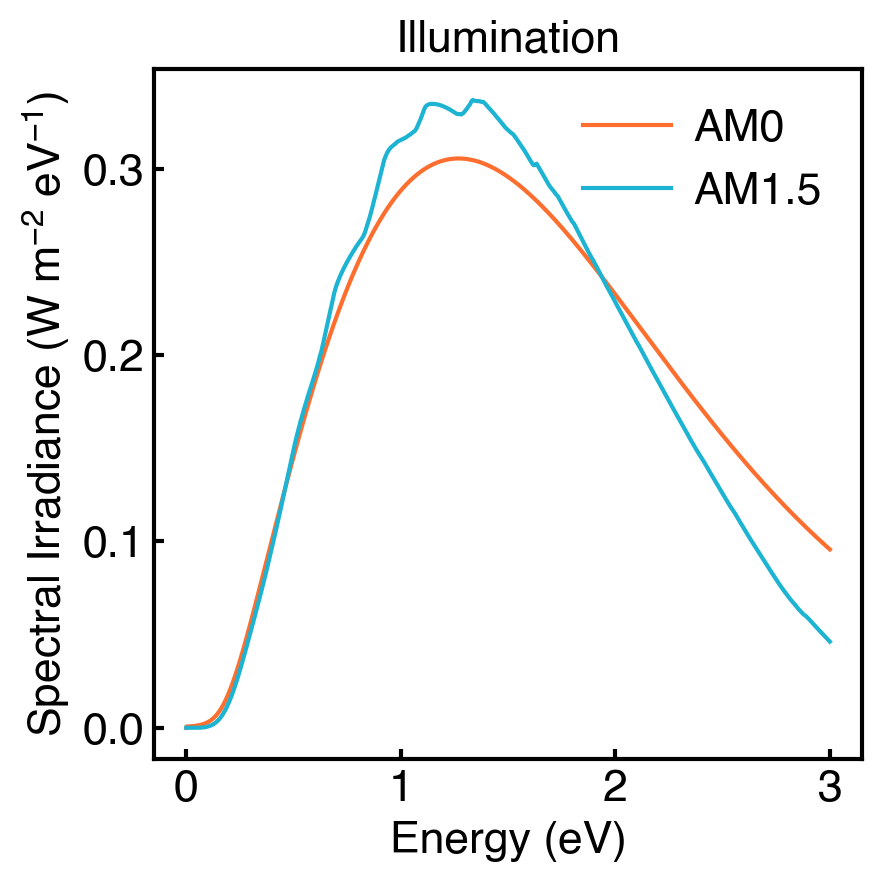

In [8]:
fig,ax=plt.subplots()
ax.plot(egs,eff_am0,label='AM0')
ax.plot(egs,eff_am1p5,label='AM1.5')
ax.set_xlabel("Energy (eV)")
ax.set_ylabel("Spectral Irradiance (W $m^{-2}$ $eV^{-1}$)")
ax.legend(loc="upper right")
ax.set_title('Illumination')
fig.savefig('test')
#xlim([0,5])